# Sparsity and Importance Metrics

In this notebook, we explore weight sparsity in LLMs and how the choice of importance metric affects the performance of a sparse pruned LLM. For this, we use Llama-2-7B and a caliberation dataset of 128 samples from the `wikitext 2`, `c4`, and `fineweb-edu` dataset with context length 4096.

In [1]:
%load_ext autoreload
%autoreload 2

from utils import *
import matplotlib.pyplot as plt

/home/user/.conda/envs/esie/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Model and Tokenizer

In [2]:
model_name = "meta-llama/Llama-2-7b-hf"
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", dtype=torch.float16)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


### Calibration datasets

In [3]:
# Calibration datasets
NUM_SAMPLES = 128
SEQUENCE_LEN = 4096

# Load the train and test data for the calibration datasets
w2_train_data, w2_test_data = get_w2_data(NUM_SAMPLES, SEQUENCE_LEN, tokenizer)
c4_train_data, c4_test_data = get_c4_data(NUM_SAMPLES, SEQUENCE_LEN, tokenizer)

num_tokens = NUM_SAMPLES * SEQUENCE_LEN
fw_train_data = get_fineweb_edu(num_tokens, SEQUENCE_LEN, tokenizer, train=True)
fw_test_data = get_fineweb_edu(num_tokens, SEQUENCE_LEN, tokenizer, train=False)

Repo card metadata block was not found. Setting CardData to empty.
Repo card metadata block was not found. Setting CardData to empty.


Loading FineWeb-Edu v2
Total tokens loaded: 524288
Loading FineWeb-Edu v2
Total tokens loaded: 524288


# Wanda and BaWa reconstruction error vs perplexity

The metrics used for Wanda considers the norm of the corresponding input activation channel for a weight matrix. This is done to account for outliers in the input activations, since large activation values lead to large reconstruction errors. In this section, we prune Llama-2-7B with Wanda measuring the total reconstruction error and the resulting perplexity on the calibration dataset. 

$$\text{Wanda}(W_{ij}) = |W_{ij}| \cdot ||X_{i}||_2$$

Likewise we prune using BaWa, which is a more recent importance metric that scales the sum of the weight magnitude normalized by the input and output weight channels by the input activation norm.

$$\text{BaWa}(W_{ij}) = \left(\frac{1}{||W_{:,j}||_2^{\theta_1}} + \frac{1}{||W_{i,:}||_2^{\theta_2}}\right) \cdot |W_{ij}| \cdot ||X_{j}||_2^{\theta_3}$$

It is desired that the reconstruction error correlates with the perplexity, since it is assumed that lower reconstruction errors should lead to better model performance. In this experiment we assume uniform sparsity across all layers.

loading calibration data
dataset loading complete


Layer 0 reconstruction error: 11441.005859375
Layer 1 reconstruction error: 9351807.0
Layer 2 reconstruction error: 274400.59375
Layer 3 reconstruction error: 706892.625
Layer 4 reconstruction error: 1269675.25
Layer 5 reconstruction error: 1694654.25
Layer 6 reconstruction error: 2636122.0
Layer 7 reconstruction error: 3281211.0
Layer 8 reconstruction error: 4239341.0
Layer 9 reconstruction error: 5059146.0
Layer 10 reconstruction error: 6479130.0
Layer 11 reconstruction error: 7518843.5
Layer 12 reconstruction error: 8217330.0
Layer 13 reconstruction error: 9910827.0
Layer 14 reconstruction error: 10873020.0
Layer 15 reconstruction error: 13096830.0
Layer 16 reconstruction error: 17476072.0
Layer 17 reconstruction error: 16830506.0
Layer 18 reconstruction error: 19834040.0
Layer 19 reconstruction error: 20953126.0
Layer 20 reconstruction error: 26149884.0
Layer 21 reconstruction error: 24484050.0
Layer 22 reconstruction error: 29179904.0
Layer 23 reconstruction error: 29422856.0
Laye

Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it]


loading calibration data
dataset loading complete
Layer 0 reconstruction error: 13215.22265625
Layer 1 reconstruction error: 7940479.5
Layer 2 reconstruction error: 280266.90625
Layer 3 reconstruction error: 568977.0
Layer 4 reconstruction error: 1040457.125
Layer 5 reconstruction error: 1684481.0
Layer 6 reconstruction error: 2687098.0
Layer 7 reconstruction error: 3356463.5
Layer 8 reconstruction error: 4334356.5
Layer 9 reconstruction error: 5164618.0
Layer 10 reconstruction error: 6679538.0
Layer 11 reconstruction error: 7656816.0
Layer 12 reconstruction error: 8504510.0
Layer 13 reconstruction error: 10194206.0
Layer 14 reconstruction error: 11401373.0
Layer 15 reconstruction error: 13357888.0
Layer 16 reconstruction error: 17937960.0
Layer 17 reconstruction error: 17720508.0
Layer 18 reconstruction error: 20935068.0
Layer 19 reconstruction error: 21864524.0
Layer 20 reconstruction error: 28100494.0
Layer 21 reconstruction error: 25951944.0
Layer 22 reconstruction error: 31255114.

Text(0.5, 1.0, 'Layer-wise Reconstruction Error after Pruning w/ Wanda and BaWa \n(50% sparsity) Llama-2-7B')

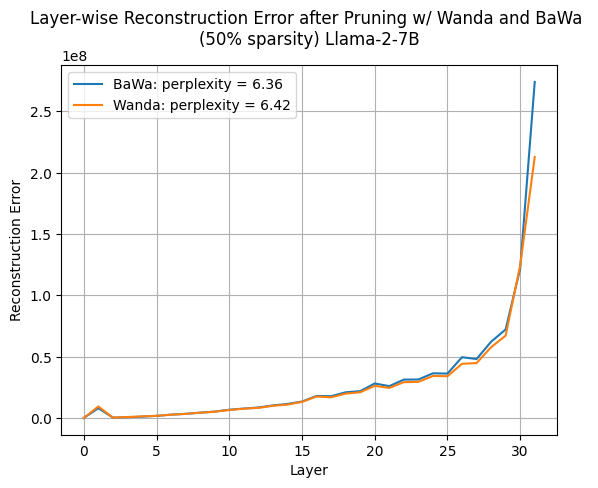

In [4]:
reconstruction_errors = prune_default(model, fw_train_data, 0.5, theta1=0, theta2=0, theta3=1)
perplexity = eval_ppl(model, w2_test_data, SEQUENCE_LEN,  bs=1, device="cuda")

del model
gc.collect()
torch.cuda.empty_cache()

model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", dtype=torch.float16)
bawa_reconstruction_errors = prune_default(model, fw_train_data, 0.5)
bawa_perplexity = eval_ppl(model, w2_test_data, SEQUENCE_LEN,  bs=1, device="cuda")

# plot the reconstruction errors. Give appropriate labels and title
# write the perplexity on the plot
plt.plot(bawa_reconstruction_errors)
plt.plot(reconstruction_errors)
plt.legend([f"BaWa: perplexity = {bawa_perplexity:.2f}", f"Wanda: perplexity = {perplexity:.2f}"])
plt.xlabel("Layer")
plt.ylabel("Reconstruction Error")
plt.grid()
plt.title("Layer-wise Reconstruction Error after Pruning w/ Wanda and BaWa \n(50% sparsity) Llama-2-7B", wrap=True)
# plt.text(0.5, max(reconstruction_errors)*0.9, f"Perplexity: {perplexity:.2f}", fontsize=12);

### Results for 60% sparsity

In [ ]:
del model
gc.collect()
torch.cuda.empty_cache()

model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", dtype=torch.float16)
reconstruction_errors = prune_default(model, fw_train_data, 0.6, theta1=0, theta2=0, theta3=1)
perplexity = eval_ppl(model, w2_test_data, SEQUENCE_LEN,  bs=1, device="cuda")

del model
gc.collect()
torch.cuda.empty_cache()

model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", dtype=torch.float16)
bawa_reconstruction_errors = prune_default(model, fw_train_data, 0.6)
bawa_perplexity = eval_ppl(model, w2_test_data, SEQUENCE_LEN,  bs=1, device="cuda")

# plot the reconstruction errors. Give appropriate labels and title
# write the perplexity on the plot
plt.plot(bawa_reconstruction_errors)
plt.plot(reconstruction_errors)
plt.legend([f"BaWa: perplexity = {bawa_perplexity:.2f}", f"Wanda: perplexity = {perplexity:.2f}"])
plt.xlabel("Layer")
plt.ylabel("Reconstruction Error")
plt.grid()
plt.title("Layer-wise Reconstruction Error after Pruning w/ Wanda and BaWa \n(60% sparsity) Llama-2-7B", wrap=True)
# plt.text(0.5, max(reconstruction_errors)*0.9, f"Perplexity: {perplexity:.2f}", fontsize=12);

Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


loading calibration data
dataset loading complete
Layer 0 reconstruction error: 28530.67578125
Layer 1 reconstruction error: 37419560.0
Layer 2 reconstruction error: 463252.53125
Layer 3 reconstruction error: 1105497.5
Layer 4 reconstruction error: 2434493.5
Layer 5 reconstruction error: 3429718.0
Layer 6 reconstruction error: 5451325.0
Layer 7 reconstruction error: 6756340.5
Layer 8 reconstruction error: 8506874.0
Layer 9 reconstruction error: 9950883.0
Layer 10 reconstruction error: 12420040.0
Layer 11 reconstruction error: 15208151.0
Layer 12 reconstruction error: 16159306.0
Layer 13 reconstruction error: 19225638.0
Layer 14 reconstruction error: 21507504.0
Layer 15 reconstruction error: 24368258.0
Layer 16 reconstruction error: 33292494.0
Layer 17 reconstruction error: 30961714.0
Layer 18 reconstruction error: 35721096.0
Layer 19 reconstruction error: 36136128.0
Layer 20 reconstruction error: 46853416.0
Layer 21 reconstruction error: 41436672.0
Layer 22 reconstruction error: 487452

### 70% sparsity

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

loading calibration data
dataset loading complete
Layer 0 reconstruction error: 41162.4741191864
Layer 1 reconstruction error: 1295822.214416504
Layer 2 reconstruction error: 894618.1077880859
Layer 3 reconstruction error: 1878173.7534179688
Layer 4 reconstruction error: 2472923.1962890625
Layer 5 reconstruction error: 2748715.923828125
Layer 6 reconstruction error: 3369367.6328125
Layer 7 reconstruction error: 3919603.8671875
Layer 8 reconstruction error: 4075820.7890625
Layer 9 reconstruction error: 4314466.45703125
Layer 10 reconstruction error: 4209886.7734375
Layer 11 reconstruction error: 5001823.46875
Layer 12 reconstruction error: 4958517.015625
Layer 13 reconstruction error: 5129489.78125
Layer 14 reconstruction error: 5483618.71875
Layer 15 reconstruction error: 5514606.8984375
Layer 16 reconstruction error: 5852351.15625
Layer 17 reconstruction error: 5911993.3125
Layer 18 reconstruction error: 6130370.5390625
Layer 19 reconstruction error: 6185625.703125
Layer 20 reconstruc

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

loading calibration data
dataset loading complete
Layer 0 reconstruction error: 48203.0446434021
Layer 1 reconstruction error: 1059773.1342773438
Layer 2 reconstruction error: 962793.7185058594
Layer 3 reconstruction error: 1942683.536743164
Layer 4 reconstruction error: 2289977.4365234375
Layer 5 reconstruction error: 2854861.546875
Layer 6 reconstruction error: 3885304.19140625
Layer 7 reconstruction error: 4466388.6171875
Layer 8 reconstruction error: 4573081.81640625
Layer 9 reconstruction error: 4642021.16796875
Layer 10 reconstruction error: 4748799.328125
Layer 11 reconstruction error: 5649864.40625
Layer 12 reconstruction error: 5473271.6328125
Layer 13 reconstruction error: 5563297.46875
Layer 14 reconstruction error: 6138029.296875
Layer 15 reconstruction error: 6233951.578125
Layer 16 reconstruction error: 6714793.40625
Layer 17 reconstruction error: 6862527.5
Layer 18 reconstruction error: 7135099.28125
Layer 19 reconstruction error: 7028037.25
Layer 20 reconstruction error

Text(0.5, 1.0, 'Layer-wise Reconstruction Error after Pruning w/ Wanda and BaWa \n(60% sparsity) Llama-2-7B')

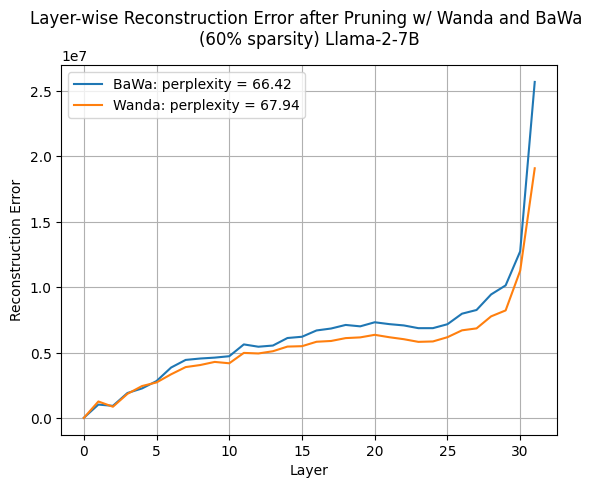

In [ ]:
del model
gc.collect()
torch.cuda.empty_cache()

model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", dtype=torch.float16)
reconstruction_errors = prune_default(model, fw_train_data, 0.7, theta1=0, theta2=0, theta3=1)
perplexity = eval_ppl(model, w2_test_data, SEQUENCE_LEN,  bs=1, device="cuda")

del model
gc.collect()
torch.cuda.empty_cache()

model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", dtype=torch.float16)
bawa_reconstruction_errors = prune_default(model, fw_train_data, 0.7)
bawa_perplexity = eval_ppl(model, w2_test_data, SEQUENCE_LEN,  bs=1, device="cuda")

# plot the reconstruction errors. Give appropriate labels and title
# write the perplexity on the plot
plt.plot(bawa_reconstruction_errors)
plt.plot(reconstruction_errors)
plt.legend([f"BaWa: perplexity = {bawa_perplexity:.2f}", f"Wanda: perplexity = {perplexity:.2f}"])
plt.xlabel("Layer")
plt.ylabel("Reconstruction Error")
plt.grid()
plt.title("Layer-wise Reconstruction Error after Pruning w/ Wanda and BaWa \n(60% sparsity) Llama-2-7B", wrap=True)
# plt.text(0.5, max(reconstruction_errors)*0.9, f"Perplexity: {perplexity:.2f}", fontsize=12);

# Influence of outliers on recontruction error and perplexity